In [1]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torch.utils.data import Dataset, DataLoader

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# For train-validation-test split (if we want to do it manually)
import random
from math import floor

import os

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Helper Functions (from Amar)
def get_img_dict(img_dir):
    img_files = [x for x in img_dir.iterdir() if x.name.endswith('.png') or x.name.endswith('.tiff')]
    img_files.sort()

    img_dict = {}
    for img_file in img_files:
        img_type = img_file.name.split('_')[0] 
        if img_type not in img_dict:
            img_dict[img_type] = []
        img_dict[img_type].append(img_file)
    return img_dict

def get_sample_dict(sample_dir):

    camera_dirs = [x for x in sample_dir.iterdir() if 'camera' in x.name]
    camera_dirs.sort()
    
    sample_dict = {}

    for cam_dir in camera_dirs:
        cam_dict = {}
        cam_dict['scene'] = get_img_dict(cam_dir)

        obj_dirs = [x for x in cam_dir.iterdir() if 'obj_' in x.name]
        obj_dirs.sort()
        
        for obj_dir in obj_dirs:
            cam_dict[obj_dir.name] = get_img_dict(obj_dir)

        sample_dict[cam_dir.name] = cam_dict

    return sample_dict

In [4]:
def make_dataset11(videos_dir: str, 
                   ind: int or None = None,  # type: ignore
                   random_seed: int = 42, 
                   max_videos: int = None) -> tuple[torch.tensor, torch.tensor, list[dict]]: 
    """ 
    Loads one frame for every object viewed from every camera angle in every video in videos_dir and 
    returns the modal masks and amodal masks in tensor form.

    Parameters:
        - videos_dir: a directory where each sub-directory contains a video from Movi-MC-AC
        - inds: a list of the same length as the number of videos telling which frame of each video to load into the dataset
        - random_seed: an integer to set the random seed. Only necessary if inds is None.
        - max_videos: the maximum number of video directories to read in. If None, read in all directories in the folder.

    Returns: 
        - a tensor of modal masks
        - a tensor of amodal masks
        - a tensor of RGB content images
        - a list of dictionaries, where each dictionary stores ALL images from a single video. TODO: abstract this into a separate function
    """

    # Save the RNG state to restore it after we're done
    prev_state = random.getstate()
    random.seed(random_seed)

    # Load a dictionary storing each video file
    video_list = os.listdir(videos_dir)
    video_list = [video for video in video_list if not video.endswith('.tar.gz')]
    
    if max_videos is None:
        max_videos = len(video_list)
    
    video_dicts = [get_sample_dict(Path(videos_dir) / Path(sample_dir)) for sample_dir in video_list[:max_videos]]

    num_vids = len(video_dicts)
    
    # Every video in Movi-MC-AC has 24 frames and 6 camera angles
    num_cams = 6 
    num_frames = 24 
    
    # If user does not specify, take one random frame from each video
    inds = None
    if ind is None: 
        inds = [random.randint(0, num_frames - 1) for i in range(num_vids)]
    else: 
        inds = [ind] * num_vids
        
    random.setstate(prev_state)

    # Count number of objects in each video
    num_obj_list = [None] * num_vids 
    for i in range(num_vids):
        num_obj_list[i] = sum([s.startswith('obj') for s in video_dicts[i]['camera_0000'].keys()])

    num_obj = sum(num_obj_list)

    # Sample size
    dataset_len = num_vids * num_cams * num_obj
    
    rgb_content = torch.empty((dataset_len, 3, 256, 256))
    modal_masks = torch.empty((dataset_len, 256, 256))
    amodal_masks = torch.empty((dataset_len, 256, 256))
    amodal_content = torch.empty((dataset_len, 3, 256, 256))

    l = 0 # iterates through l = 0, ..., dataset_len - 1
    for i in range(num_vids): # for each video
        video_dict = video_dicts[i]
        cur_num_obj = num_obj_list[i]
        for j in range(num_cams): # for each camera angle
            cam_dict = video_dict[f'camera_{j:04d}']
            cur_modal_masks = Image.open(cam_dict['scene']['segmentation'][inds[i]]) # load the modal masks
            rgb_image = Image.open(cam_dict['scene']['rgba'][inds[i]]).convert('RGB')
            cur_rgb_content = image_to_tensor(rgb_image)
            for k in range(cur_num_obj): # for each object
                amodal_mask = Image.open(cam_dict[f'obj_{k+1:04d}']['segmentation'][inds[i]]) # load the amodal mask
                amodal_mask = image_to_tensor(amodal_mask)

                cur_amodal_content = Image.open(cam_dict[f'obj_{k+1:04d}']['rgba'][inds[i]]).convert('RGB')
                cur_amodal_content = image_to_tensor(cur_amodal_content)

                modal_mask = (torch.tensor(np.array(cur_modal_masks)) == (k + 1)).float() # extract the modal mask of a single object

                rgb_content[l,:,:,:] = cur_rgb_content
                modal_masks[l,:,:] = modal_mask 
                amodal_masks[l,:,:] = amodal_mask
                amodal_content[l,:,:,:] = cur_amodal_content
                l += 1
    
    modal_masks = modal_masks.unsqueeze(1)
    amodal_masks = amodal_masks.unsqueeze(1)

    return rgb_content, modal_masks, amodal_masks, amodal_content, video_dicts


In [5]:
def print_all_four(idx, rgb_content = None, modal_masks = None, amodal_masks = None, 
                   amodal_content = None, batch = None): 
    if batch is not None:
        rgb_content, modal_masks, amodal_masks, amodal_content = batch
    
    fig, axes = plt.subplots(2, 2)

    axes[0,0].imshow(tensor_to_image(rgb_content[idx]), cmap='gray')
    axes[0,0].set_title("RGB Content")
    axes[0,0].axis('off')

    axes[0,1].imshow(tensor_to_image(modal_masks[idx]), cmap='gray')
    axes[0,1].set_title("Modal Mask")
    axes[0,1].axis('off')

    axes[1,0].imshow(tensor_to_image(amodal_masks[idx]), cmap='gray')
    axes[1,0].set_title("Amodal Mask")
    axes[1,0].axis('off')

    axes[1,1].imshow(tensor_to_image(amodal_content[idx]), cmap='gray')
    axes[1,1].set_title("Amodal Content")
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
data_dir = '/usr/workspace/dssi-dsc/subset_data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_rgb, train_modal, train_amasks, train_acontent, train_videos = make_dataset11(train_dir, 
                                                          0, max_videos = 4) # take the first frame of the video

test_rgb, test_modal, test_amasks, test_acontent, test_videos = make_dataset11(test_dir, 
                                                          0, max_videos = 1)
# 10 videos takes long enough to load

In [23]:
train_rgb.shape

torch.Size([2424, 3, 256, 256])

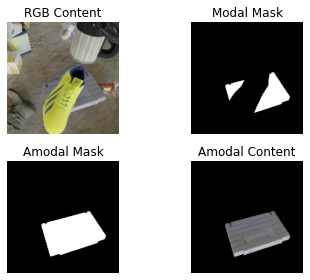

torch.Size([2424, 3, 256, 256])


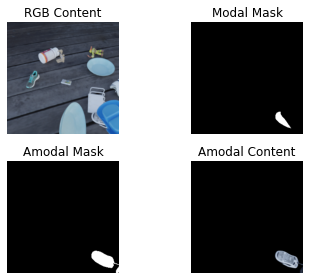

torch.Size([108, 3, 256, 256])


In [24]:
print_all_four(1, train_rgb, train_modal, train_amasks, train_acontent)
print(train_rgb.shape)

print_all_four(7, test_rgb, test_modal, test_amasks, test_acontent)
print(test_rgb.shape)
# TODO: put more images in test

In [25]:
class Task_1_1_Dataset(Dataset):
    def __init__(self, rgb_content, modal_masks, amodal_masks, amodal_content):
        self.rgb_content = rgb_content
        self.modal_masks = modal_masks
        self.amodal_masks = amodal_masks
        self.amodal_content = amodal_content

    def __len__(self):
        return self.rgb_content.shape[0]
    
    def __getitem__(self, index):
        return (self.rgb_content[index], self.modal_masks[index], 
               self.amodal_masks[index], self.amodal_content[index])

In [26]:
def Fscore(pred, truth): 
    pred_pos = (pred == 1)
    actual_pos = (truth == 1)

    true_pos = pred_pos & actual_pos 
    num_true_pos = true_pos.sum()

    num_pred_pos = pred_pos.sum()
    num_actual_pos = actual_pos.sum()

    prec = 0 if num_pred_pos == 0 else float(num_true_pos) / float(num_pred_pos)
    rec = 0 if num_actual_pos == 0 else float(num_true_pos) / float(num_actual_pos)

    if (prec + rec) == 0:
        return 0.0

    return 2 * prec * rec / (prec + rec)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv2d_inplace_spatial(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, pooling_function, activation = nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Upscale(nn.Module):
    def __init__(self, scale_factor=(2, 2), mode='bilinear', align_corners=False):
        super(Upscale, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet11(nn.Module):
    def __init__(self, in_channels = 4):
        super().__init__()

        self.mpool_2 = nn.MaxPool2d((2, 2))

        self.down1 = conv2d_inplace_spatial(in_channels, 32, self.mpool_2)
        self.down2 = conv2d_inplace_spatial(32, 64, self.mpool_2)
        self.down3 = conv2d_inplace_spatial(64, 128, self.mpool_2)
        self.down4 = conv2d_inplace_spatial(128, 256, self.mpool_2)

        self.upscale_2 = Upscale(scale_factor=(2, 2), mode='bilinear', align_corners=False)

        self.up1 = conv2d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv2d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv2d_inplace_spatial(128, 32, self.upscale_2)
        
        self.up4_amodal_mask = conv2d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        # self.up4_amodal_content = conv2d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        # self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?

        # Optimization
        # self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()

        # Self-attention feature enrichment
        #max_seq = 16*16*6
        #token_dim = 256
        #self.pos_enc = nn.Parameter(torch.zeros((max_seq, 1, token_dim))) # seq b dim
        #encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=8)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        
    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        return x1, x2, x3, x4
    
    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)
        
        logits_amodal_mask = self.up4_amodal_mask(h1234)
        # logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask# , logits_amodal_content
    
    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w)
        """
        b, c, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        # logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)
        logits_amodal_mask = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask# , logits_amodal_content
        
    def forward(self, batch_rgb, batch_modal, batch_amasks): # , batch_acontent):
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch_rgb, batch_modal), dim = 1)
    
        # TODO: ask a question about this. Currently, this does nothing
        # Remove time dimension from a few things (add it back in later when you make your video model!)
        model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
        amodal_mask_labels = batch_amasks.float().squeeze(2)
        # amodal_content_labels = batch_acontent.float().squeeze(2)
        # [batchsize, channels, height, width]
        # []

        # Model input
        #print('model input:', model_input.shape)
        
        # logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)
        logits_amodal_mask = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        # if self.mask_content_preds:
        #     # Element-wise masking by self-predictions:
        #     logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # Loss between predicted amodal masks/content and GT masks/content
        # mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
        #                                                 amodal_mask_labels,
        #                                                 logits_amodal_content, 
        #                                                 amodal_content_labels)
        
        # loss = mask_loss + content_loss

        loss = self.loss_function(logits_amodal_mask, 
                                  amodal_mask_labels)

        # Calculate metrics into a dictionary
        # TODO: ask why we don't calculate loss metrics on the [0, 255] amodal content?
        F_score = Fscore(logits_amodal_mask.sigmoid().round(), amodal_mask_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = F_score

        return loss, metrics
    
    
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels): # ,
                    # amodal_content_preds,
                    # amodal_content_labels):
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels)
        # content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels)
        return mask_loss# , content_loss

class Unet12(nn.Module):
    def __init__(self, in_channels = 4, mask_content_preds = False):
        super().__init__()

        self.mpool_2 = nn.MaxPool2d((2, 2))

        self.down1 = conv2d_inplace_spatial(in_channels, 32, self.mpool_2)
        self.down2 = conv2d_inplace_spatial(32, 64, self.mpool_2)
        self.down3 = conv2d_inplace_spatial(64, 128, self.mpool_2)
        self.down4 = conv2d_inplace_spatial(128, 256, self.mpool_2)

        self.upscale_2 = Upscale(scale_factor=(2, 2), mode='bilinear', align_corners=False)

        self.up1 = conv2d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv2d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv2d_inplace_spatial(128, 32, self.upscale_2)
        
        self.up4_amodal_mask = conv2d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        self.up4_amodal_content = conv2d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?

        # Optimization
        self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()

        # Self-attention feature enrichment
        #max_seq = 16*16*6
        #token_dim = 256
        #self.pos_enc = nn.Parameter(torch.zeros((max_seq, 1, token_dim))) # seq b dim
        #encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=8)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        
    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        return x1, x2, x3, x4
    
    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)
        
        logits_amodal_mask = self.up4_amodal_mask(h1234)
        logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask, logits_amodal_content
    
    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w)
        """
        b, c, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask, logits_amodal_content
        
    def forward(self, batch_rgb, batch_modal, batch_amasks, batch_acontent):
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch_rgb, batch_modal), dim = 1)
    
        # TODO: ask a question about this. Currently, this does nothing
        # Remove time dimension from a few things (add it back in later when you make your video model!)
        model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
        amodal_mask_labels = batch_amasks.float().squeeze(2)
        amodal_content_labels = batch_acontent.float().squeeze(2)
        # [batchsize, channels, height, width]
        # []

        # Model input
        #print('model input:', model_input.shape)
        
        logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Calculate metrics into a dictionary
        # TODO: ask why we don't calculate loss metrics on the [0, 255] amodal content?
        F_score = Fscore(logits_amodal_mask.sigmoid().round(), amodal_mask_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        
        metrics = f"""Mask Loss: {float(mask_loss):.4f}, Content Loss: {float(content_loss):.4f} 
                   F Score: {float(F_score):.4f}"""

        return loss, metrics
    
    
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels)
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels)
        return mask_loss, content_loss

In [28]:
def train_val_split(rgb_content: torch.tensor, 
                    modal_masks: torch.tensor, 
                    amodal_masks: torch.tensor, 
                    amodal_content: torch.tensor,
                    props: tuple[float, float], 
                    random_seed: int = 42) -> list[torch.tensor]:
    ''' 
    Split training data tensors into train & validation sets according to proportions `probs`.

    Parameters:
        - rgb_content
        - modal_masks
        - amodal_masks
        - amodal_content
        - props: a length 2 tuple which must sum to 1. probs = (0.8, 0.2) specifies 80% of the data 
        in training and 20% of the data in validation.
        - random_seed: Integer to set the RNG state. RNG is set back to its previous state after the function call.
    
    Return:
        - 8 tensors: input tensors split into train & validation sets.

    Details:
    
    Validation data should be used for hyperparameter tuning, model selection, and deciding when to 
    stop training. It should not be used to test final model performance.
    '''
    # Make sure proportions sum to 1, within floating point error
    if (abs(sum(props) - 1)) >= 1e-4: 
        raise ValueError("props must sum to 1")
    
    n = rgb_content.shape[0]

    val_size = floor(n * props[1])

    # Make sure test size is not accidentally rounded to 0
    if props[1] > 1e-4:
        val_size = max(val_size, 1)

    data_inds = range(n)

    prev_state = random.getstate()
    random.seed(random_seed)
    val_inds = random.sample(data_inds, val_size)

    rgb_val = rgb_content[val_inds]
    modal_val = modal_masks[val_inds]
    amasks_val = amodal_masks[val_inds]
    acontent_val = amodal_content[val_inds]

    train_inds = list(set(data_inds) - set(val_inds))
    random.shuffle(train_inds)

    random.setstate(prev_state)

    rgb_train = rgb_content[train_inds]
    modal_train = modal_masks[train_inds]
    amasks_train = amodal_masks[train_inds]
    acontent_train = amodal_content[train_inds]

    # Returning 8 tensors in a list like this is pretty disgusting
    # But I don't want to spend time fixing this
    return rgb_train, modal_train, amasks_train, acontent_train, rgb_val, modal_val, amasks_val, acontent_val

In [29]:
train_rgb, train_modal, train_amasks, train_acontent, val_rgb, val_modal, val_amasks, val_acontent = train_val_split(train_rgb, train_modal, train_amasks, train_acontent, props = (0.8, 0.2))

task1_train = Task_1_1_Dataset(train_rgb, train_modal, train_amasks, train_acontent)
task1_val = Task_1_1_Dataset(val_rgb, val_modal, val_amasks, val_acontent)

task11_model = Unet11()
task11_model.to(device)
optimizer = torch.optim.Adam(task11_model.parameters(), lr = 1e-2)

task11_train_dl = DataLoader(task1_train, batch_size = 16)
task11_val_dl = DataLoader(task1_val, batch_size = 16)

In [30]:
len(task11_train_dl)

122

In [31]:
n_epochs = 100

for i in range(n_epochs):
    # print(f"Epoch {i+1}:")
    task11_model.train()
    for j, (batch_rgb, batch_modal, batch_amask, batch_acontent) in enumerate(task11_train_dl): 
        batch_rgb = batch_rgb.to(device)
        batch_modal = batch_modal.to(device)
        batch_amask = batch_amask.to(device)
        # batch_acontent = batch_acontent.to(device)
        
        optimizer.zero_grad()
        
        loss, metrics = task11_model(batch_rgb, batch_modal, batch_amask)
        print(f"Epoch {i+1}: Mini-batch {j+1}: Training Loss: {float(loss.item()):<6.4f}, Training F-Score:   {metrics:<6.4f}", 
              end='\r', flush=True)
              
        loss.backward()
        optimizer.step()
    
    task11_model.eval()
    val_losses = []
    val_metrics = []
    with torch.no_grad(): # protects against CUDA OutOfMemoryError
        for val_rgb_batch, val_modal_batch, val_amask_batch, val_acontent_batch in task11_val_dl:
            val_rgb_batch = val_rgb_batch.to(device)
            val_modal_batch = val_modal_batch.to(device)
            val_amask_batch = val_amask_batch.to(device)
            
            val_loss, val_metric = task11_model(val_rgb_batch, val_modal_batch, val_amask_batch)
            val_losses.append(val_loss.item())
            val_metrics.append(val_metric)
            
        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_val_metrics = sum(val_metrics) / len(val_metrics)

        print(f"Epoch {i+1}: Mini-batch {len(task11_train_dl)}: Training Loss:   {float(loss.item()):<6.4f}, Training F-Score:   {float(metrics):<6.4f}\nEpoch {i+1}: Mini-batch {len(task11_train_dl)}: Validation Loss: {float(avg_val_loss):<6.4f}, Validation F-score: {float(avg_val_metrics):<6.4f}\n")
    

Epoch 1: Mini-batch 122: Training Loss:   0.3100, Training F-Score:   0.0000
Epoch 1: Mini-batch 122: Validation Loss: 0.2958, Validation F-score: 0.6103

Epoch 2: Mini-batch 122: Training Loss:   0.1590, Training F-Score:   0.0000
Epoch 2: Mini-batch 122: Validation Loss: 0.1597, Validation F-score: 0.0000

Epoch 3: Mini-batch 122: Training Loss:   0.0950, Training F-Score:   0.0000
Epoch 3: Mini-batch 122: Validation Loss: 0.1010, Validation F-score: 0.0000

Epoch 4: Mini-batch 122: Training Loss:   0.0658, Training F-Score:   0.0000
Epoch 4: Mini-batch 122: Validation Loss: 0.0776, Validation F-score: 0.0000

Epoch 5: Mini-batch 122: Training Loss:   0.0479, Training F-Score:   0.0000
Epoch 5: Mini-batch 122: Validation Loss: 0.0592, Validation F-score: 0.0000

Epoch 6: Mini-batch 122: Training Loss:   0.0367, Training F-Score:   0.0000
Epoch 6: Mini-batch 122: Validation Loss: 0.0474, Validation F-score: 0.0000

Epoch 7: Mini-batch 122: Training Loss:   0.0300, Training F-Score:   

KeyboardInterrupt: 

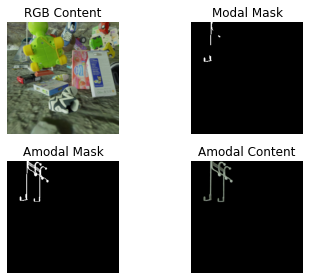

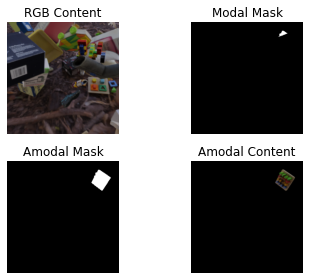

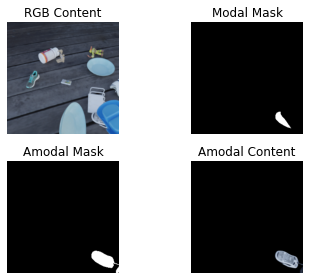

In [41]:
# Now, check model performance on train, validation, and test
print_all_four(0, train_rgb, train_modal, train_amasks, train_acontent)
print_all_four(8, val_rgb, val_modal, val_amasks, val_acontent)
print_all_four(7, test_rgb, test_modal, test_amasks, test_acontent)

In [42]:
def make_one_pred(rgb: torch.tensor, 
              modal: torch.tensor, 
              amodal_true: torch.tensor, 
              i: int) -> torch.tensor: 
    
    model_input = torch.cat((rgb[i].unsqueeze(0), modal[i].unsqueeze(0)), dim = 1)
    model_input = model_input.to(device)
    
    logits_amodal_mask = task11_model.encode_decode(model_input)
    return logits_amodal_mask.sigmoid().round()

def plot_one_pred(rgb: torch.tensor, 
              modal: torch.tensor, 
              amodal_true: torch.tensor, 
              i: int) -> None:
    
    axes = plt.subplots(2, 2)[1]
    
    axes[0, 0].imshow(tensor_to_image(rgb[i]), cmap='gray')
    axes[0, 0].set_title("RGB Content")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(tensor_to_image(modal[i]), cmap='gray')
    axes[0, 1].set_title("Modal Mask")
    axes[0, 1].axis('off')
    
    amodal_pred = make_one_pred(rgb, modal, amodal_true, i)[0]
    
    axes[1, 0].imshow(tensor_to_image(amodal_pred), cmap='gray')
    axes[1, 0].set_title("Predicted Mask")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(tensor_to_image(amodal_true[i]), cmap='gray')
    axes[1, 1].set_title("Target Mask")
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

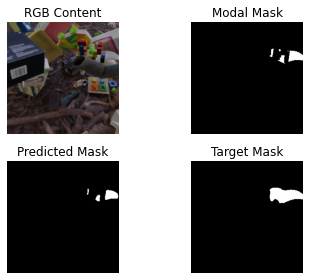

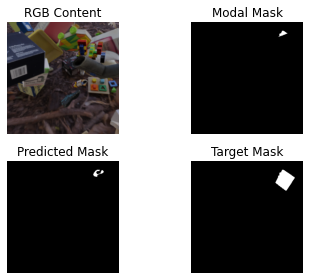

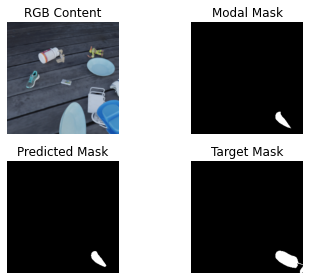

In [79]:
plot_one_pred(train_rgb, train_modal, train_amasks, 35)
plot_one_pred(val_rgb, val_modal, val_amasks, 8)
plot_one_pred(test_rgb, test_modal, test_amasks, 7)

In [ ]:
# FIXME: this is outdated
def plot_pred_batch(rgb_batch: torch.tensor, 
                    amodal_pred_batch: torch.tensor, 
                    amodal_true_batch: torch.tensor) -> None:
    batch_size = rgb_batch.shape[0]

    axes = plt.subplots(batch_size, 3)[1]

    for i in range(batch_size):
        plot_pred(rgb_batch, amodal_pred_batch, amodal_true_batch, 
                  i, axes)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_pred_batch(batch_rgb, amodal_mask_pred, batch_amask)

In [ ]:
# TODO: implement testing

In [ ]:
# TODO: add rgb content as an input
task12_model = Unet12(mask_content_preds = True)

# TODO: implement the following architecture
# One epoch is an entire pass through the dataset
# For each pass, use DataLoader to randomly shuffle the data into batches 
#   For each batch, compute the gradient and update the parameters
# task_1_1_dataloader = DataLoader(task_1_1_train, batch_size=4, shuffle=True)
# batch_rgb, batch_modal, batch_amodal = next(iter(task_1_1_dataloader))

task12_dl = DataLoader(task1_train, batch_size = 4)
batch_rgb, batch_modal, batch_amask, batch_acontent = next(iter(task12_dl))

In [ ]:
for i, batch in enumerate(task12_dl): 
    print_all_four(0, batch = batch)

In [ ]:
loss = float('inf')

optimizer = torch.optim.Adam(task12_model.parameters(), lr = 0.01)
for i in range(200): 
    loss, metrics = task12_model(batch_rgb, batch_modal, batch_amask, batch_acontent)

    # loss = loss_fn(logits, batch_acontent)
    # next_loss = loss_fn(logits, batch_rgb, batch_modal, batch_amask, batch_acontent)
    # if(float(next_loss) > float(loss) and float(loss) < 0.1): 
    #     print("Training loss increased after previous epoch. Stopping early.")
    #     break# 

    # loss = next_loss

    print(f"Epoch {i+1}: Training Loss = {float(loss)}, Metrics: {metrics}")

    # if(float(loss) < 0.1):
    #     print("Low Training Loss. Stopping early.")
    #     break

    loss.backward()
    optimizer.step()

    # TODO: train Task 1.1 on Mask Loss, train Task 1.2 on Content Loss or a 
    # weighted sum of Mask Loss and Content Loss

In [ ]:
print_all_four(0, batch_rgb, batch_modal, batch_amask, batch_acontent)

In [ ]:
# concat rgb and modal masks as input to model
model_input = torch.cat((batch_rgb, batch_modal), dim = 1)

# Remove time dimension from a few things (add it back in later when you make your video model!)
model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
amodal_mask_labels = batch_amask.float().squeeze(2)
amodal_content_labels = batch_acontent.float().squeeze(2)

logits_amodal_mask, logits_amodal_content = task12_model.encode_decode(model_input)

amodal_mask_pred = logits_amodal_mask.sigmoid().round()
amodal_content_pred = (logits_amodal_mask.sigmoid()) * 255

In [ ]:
plot_pred_batch(batch_rgb, amodal_mask_pred, batch_amask)

In [ ]:
plot_pred_batch(batch_rgb, amodal_content_pred * amodal_mask_pred, batch_amask)

# TODO: mask the predicted amodal content during training
# TODO: how to prevent the prevent the amodal content from being just a border around 
# an empty space?

In [ ]:
# TODO: try this on a different batch with occluded objects
data_iter = iter(task12_dl)
batch1 = next(data_iter)
batch2 = next(data_iter)
batch3 = next(data_iter)
for i in range(3):
    print_all_four(i, batch = batch3)

In [ ]:
task12_model = Unet12()

In [ ]:
batch_rgb, batch_modal, batch_amask, batch_acontent = batch3

In [ ]:
optimizer = torch.optim.Adam(task12_model.parameters(), lr = 0.01)
for i in range(200): 
    loss, _ = task12_model(batch_rgb, batch_modal, batch_amask, batch_acontent)
    

    # loss = loss_fn(logits, batch_acontent)
    # next_loss = loss_fn(logits, batch_rgb, batch_modal, batch_amask, batch_acontent)
    # if(float(next_loss) > float(loss) and float(loss) < 0.1): 
    #     print("Training loss increased after previous epoch. Stopping early.")
    #     break# 

    # loss = next_loss

    print(f"Epoch {i+1}: Training Loss = {float(loss)}")

    # if(float(loss) < 0.1):
    #     print("Low Training Loss. Stopping early.")
    #     break

    loss.backward()
    optimizer.step()

In [ ]:
# concat rgb and modal masks as input to model
model_input = torch.cat((batch_rgb, batch_modal), dim = 1)

# Remove time dimension from a few things (add it back in later when you make your video model!)
model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
amodal_mask_labels = batch_amask.float().squeeze(2)
amodal_content_labels = batch_acontent.float().squeeze(2)

logits_amodal_mask, logits_amodal_content = task12_model.encode_decode(model_input)
amodal_mask_pred = logits_amodal_mask.sigmoid().round()

plot_pred_batch(batch_rgb, amodal_mask_pred, batch_amask)

In [ ]:
plot_pred_batch(batch_rgb, logits_amodal_content.sigmoid() * 255 * amodal_mask_pred, batch_amask)